In [ ]:
!pip install --upgrade kagglehub

In [ ]:
import kagglehub
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Descargar las últimas versiones de los datasets
path_disaster_waste = kagglehub.dataset_download("engineeringubu/disaster-waste-dataset")
print("Path to Disaster Waste dataset files:", path_disaster_waste)

path_recyclable_household = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Path to Recyclable and Household Waste dataset files:", path_recyclable_household)

100%|██████████| 9.66G/9.66G [01:57<00:00, 88.6MB/s]

Extracting files...


Path to Disaster Waste dataset files: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1


100%|██████████| 920M/920M [00:12<00:00, 80.1MB/s]

Extracting files...


Path to Recyclable and Household Waste dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [ ]:
def filter_relevant_images(dataset_path, exclude_folders):
    #Filtra las carpetas relevantes excluyendo las especificadas.
    for root, dirs, files in os.walk(dataset_path):
        for dir_name in dirs:
            if dir_name in exclude_folders:
                shutil.rmtree(os.path.join(root, dir_name))
                print(f"Excluyendo carpeta: {dir_name}")
    print("Filtrado completo.")

# Carpetas a excluir de ambos datasets:
exclude_disaster_waste = ['Organic Wastes', 'Rubber Materials', 'Plastic Materials', 'Leather Materials']
exclude_recyclable = ['shoes', 'plastic_trash_bags', 'coffee_grounds', 'clothing']

# Filtrar las imágenes de los datasets
new_disaster_waste = filter_relevant_images(path_disaster_waste, exclude_disaster_waste)
new_recyclable = filter_relevant_images(path_recyclable_household, exclude_recyclable)

Excluyendo carpeta: Plastic Materials
Excluyendo carpeta: Rubber Materials
Excluyendo carpeta: Organic Wastes
Excluyendo carpeta: Leather Materials
Excluyendo carpeta: Plastic Materials
Excluyendo carpeta: Organic Wastes
Filtrado completo.
Excluyendo carpeta: clothing
Excluyendo carpeta: coffee_grounds
Excluyendo carpeta: plastic_trash_bags
Excluyendo carpeta: shoes
Filtrado completo.


In [ ]:
def resize_images(image_path, size=(224, 224)):
    #Redimensionar todas las imágenes en el directorio con un tamaño específico.
    #convertir a grises
    for root, dirs, files in os.walk(image_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
                    img_resized = cv2.resize(img_gray, size)
                    cv2.imwrite(os.path.join(root, file), img_resized)

# Redimensionar imágenes en ambos datasets
resize_images(path_disaster_waste)
resize_images(path_recyclable_household)

In [ ]:
def normalize_image(image):
    #Normalizar los valores de píxeles entre 0 y 1.
    return image / 255.0

def normalize_images(image_path):
    #Normalizar todas las imágenes del directorio.
    for root, dirs, files in os.walk(image_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    img_normalized = normalize_image(img)
                    cv2.imwrite(os.path.join(root, file), (img_normalized * 255).astype('uint8'))

normalize_images(path_disaster_waste)
normalize_images(path_recyclable_household)

In [ ]:
def denoise_images(image_path):
  #Aplica un filtro gaussiano para eliminar el ruido de las imágenes.
  for root, dirs, files in os.walk(image_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    img_denoised = cv2.GaussianBlur(img, (5, 5), 0)
                    cv2.imwrite(os.path.join(root, file), img_denoised)

denoise_images(path_disaster_waste)
denoise_images(path_recyclable_household)

In [ ]:
#imprimir cantidad de imagenes en cada carpeta:
for root, dirs, files in os.walk(path_disaster_waste):
    print(f"Carpeta: {root}, Cantidad de imágenes: {len(files)}")

#otro dataset
for root, dirs, files in os.walk(path_recyclable_household):
    print(f"Carpeta: {root}, Cantidad de imágenes: {len(files)}")

Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1, Cantidad de imágenes: 0
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset, Cantidad de imágenes: 0
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset/DWS-2, Cantidad de imágenes: 0
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset/DWS-2/Glass Materials, Cantidad de imágenes: 0
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset/DWS-2/Glass Materials/Train, Cantidad de imágenes: 699
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset/DWS-2/Glass Materials/Test, Cantidad de imágenes: 175
Carpeta: /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-2 dataset/DWS-2/Cement-Based Materials, Cantidad de imágene

In [ ]:
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    #Extrae características de textura usando GLCM (Matriz de Co-ocurrencia de Niveles de Gris).

    # Calcular GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

    # Extraer propiedades de la GLCM (contraste, energía, homogeneidad, correlación)
    contrast = graycoprops(glcm, 'contrast')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    correlation = graycoprops(glcm, 'correlation')

    # Combinar todas las características en un vector
    features_glcm = np.hstack([contrast, energy, homogeneity, correlation])

    return features_glcm.flatten()

In [ ]:
def extract_sift_descriptors(image):
    #Extrae descriptores locales usando SIFT para una imagen dada.
    sift = cv2.SIFT_create()  # Crear objeto SIFT
    keypoints, descriptors = sift.detectAndCompute(image, None)  # Extraer descriptores
    return descriptors

def create_bof_model(image_paths, num_clusters=50):
    #Crea un modelo BoF (Bag of Features) a partir de un conjunto de imágenes.
    sift_descriptors = []

    # Extraer descriptores SIFT para todas las imágenes
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            descriptors = extract_sift_descriptors(img)
            if descriptors is not None:
                sift_descriptors.append(descriptors)

    # Concatenar todos los descriptores
    sift_descriptors = np.vstack(sift_descriptors)

    # Aplicar K-means para crear el vocabulario visual
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(sift_descriptors)

    return kmeans

def extract_bof_features(image, kmeans_model, num_clusters=50):
    #Extrae las características BoF para una imagen dada usando el modelo de K-means.
    descriptors = extract_sift_descriptors(image)
    if descriptors is not None:
        # Asignar cada descriptor a su cluster correspondiente
        labels = kmeans_model.predict(descriptors)

        # Crear un histograma de las palabras visuales
        bof_features = np.bincount(labels, minlength=num_clusters)

        return bof_features
    return None

In [ ]:
def extract_combined_features(image_path, kmeans_model, num_clusters=50):
    #Combina las características GLCM y BoF en un solo vector.
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Leer la imagen en escala de grises

    # Extraer características GLCM
    glcm_features = extract_glcm_features(img)

    # Extraer características BoF
    bof_features = extract_bof_features(img, kmeans_model, num_clusters)

    # Concatenar las características GLCM y BoF en un solo vector
    if bof_features is not None:
        combined_features = np.hstack([glcm_features, bof_features])
    else:
        combined_features = glcm_features

    return combined_features

In [ ]:
#Recorrer carpetas y extraer características
def process_dataset(dataset_path, kmeans_model, num_clusters=50):
    all_features = []
    all_labels = []

    # Recorrer todas las subcarpetas (Train, Test)
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                # Extraer características combinadas
                features = extract_combined_features(image_path, kmeans_model, num_clusters)
                all_features.append(features)

                # Asumimos que el nombre de la carpeta (subcategoría) es la etiqueta
                label = image_path #os.path.basename(os.path.dirname(root))
                all_labels.append(label)

    return np.array(all_features), np.array(all_labels)

#Preparar los datasets
def get_image_paths(dataset_root):
    image_paths = []
    for root, dirs, files in os.walk(dataset_root):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [ ]:
# Rutas a los datasets
path_disaster_waste_train = "/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/"
path_recyclable_waste_train = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images/glass_cosmetic_containers/real_world"

#imprimir las rutas
print("Ruta al dataset de Disaster Waste (Train):", path_disaster_waste_train)
print("Ruta al dataset de Recyclable Waste (Train):", path_recyclable_waste_train)

# Recolectar todas las imágenes para crear el modelo BoF
image_paths_disaster_waste = get_image_paths(path_disaster_waste_train)
image_paths_recyclable_waste = get_image_paths(path_recyclable_waste_train)

#imprimir imagenes
print("Imágenes en el dataset de Disaster Waste (Train):", len(image_paths_disaster_waste))
print("Imágenes en el dataset de Recyclable Waste (Train):", len(image_paths_recyclable_waste))

# Crear modelo BoF (Bag of Features)
kmeans_model = create_bof_model(image_paths_disaster_waste + image_paths_recyclable_waste, num_clusters=50)

# Procesar los datasets y extraer características combinadas
disaster_waste_features, disaster_waste_labels = process_dataset(path_disaster_waste_train, kmeans_model, num_clusters=50)
recyclable_waste_features, recyclable_waste_labels = process_dataset(path_recyclable_waste_train, kmeans_model, num_clusters=50)

print("Características extraídas para residuos de desastres:", disaster_waste_features.shape)
print("Características extraídas para residuos reciclables:", recyclable_waste_features.shape)

Ruta al dataset de Disaster Waste (Train): /root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/
Ruta al dataset de Recyclable Waste (Train): /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images/glass_cosmetic_containers/real_world
Imágenes en el dataset de Disaster Waste (Train): 3242
Imágenes en el dataset de Recyclable Waste (Train): 250
Características extraídas para residuos de desastres: (3242, 54)
Características extraídas para residuos reciclables: (250, 54)


In [ ]:
disaster_waste_features[4].shape

(54,)

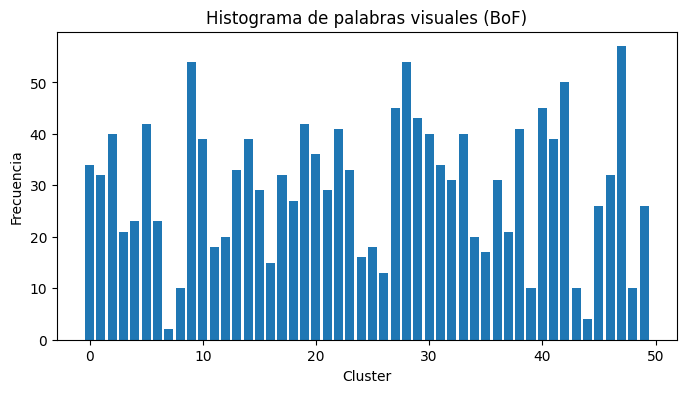

In [ ]:
def visualize_bof_histogram(image_path, kmeans_model, num_clusters=50):
    # Leer la imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Extraer las características BoF para la imagen
    bof_features = extract_bof_features(img, kmeans_model, num_clusters)

    if bof_features is not None:
        # Crear un gráfico de barras para mostrar el histograma BoF
        plt.figure(figsize=(8, 4))
        plt.bar(range(num_clusters), bof_features)
        plt.title("Histograma de palabras visuales (BoF)")
        plt.xlabel("Cluster")
        plt.ylabel("Frecuencia")
        plt.show()
    else:
        print("No se pudieron extraer características BoF para la imagen.")

# Visualizar BoF para una imagen de residuos de desastres
visualize_bof_histogram(image_paths_disaster_waste[2], kmeans_model)


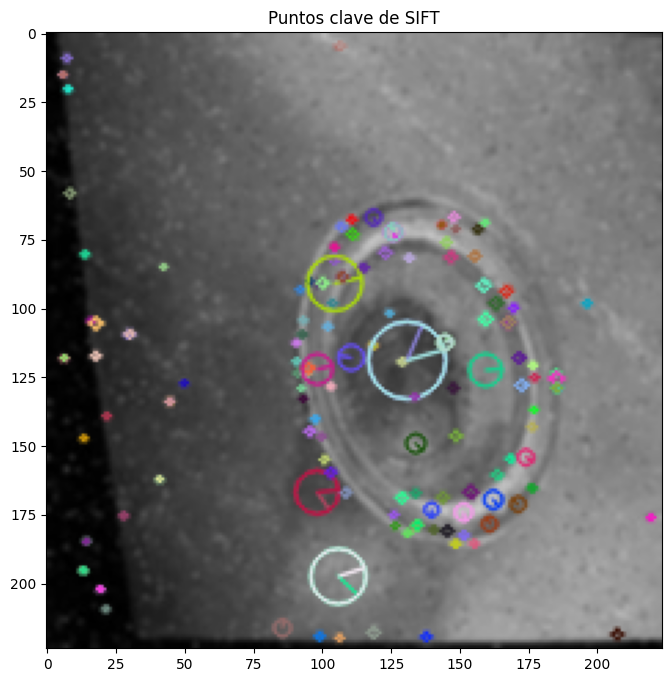

In [ ]:
def visualize_sift_keypoints(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crear el objeto SIFT
    sift = cv2.SIFT_create()

    # Detectar los puntos clave en la imagen
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Dibujar los puntos clave en la imagen
    img_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Mostrar la imagen con los puntos clave
    plt.figure(figsize=(8, 8))
    plt.imshow(img_keypoints, cmap='gray')
    plt.title("Puntos clave de SIFT")
    plt.show()

# Llamar a la función para una imagen de ejemplo
visualize_sift_keypoints(image_paths_disaster_waste[0])


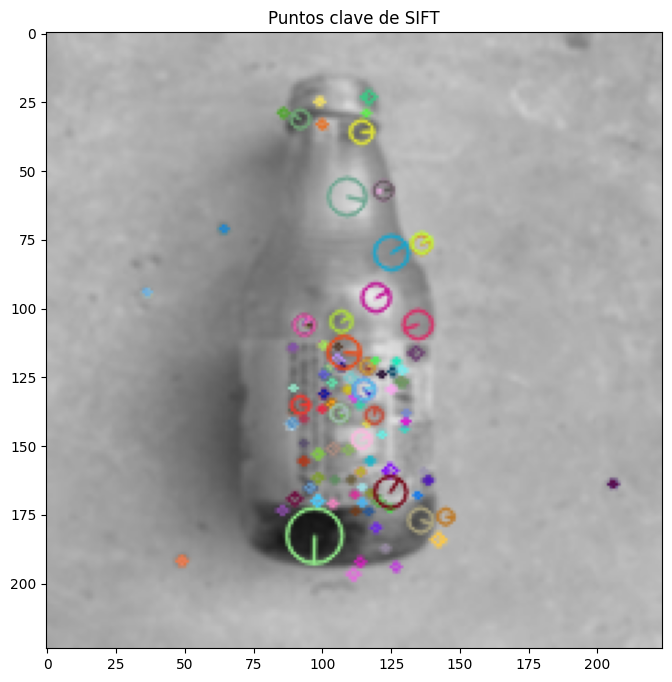

In [ ]:
visualize_sift_keypoints(image_paths_disaster_waste[90])


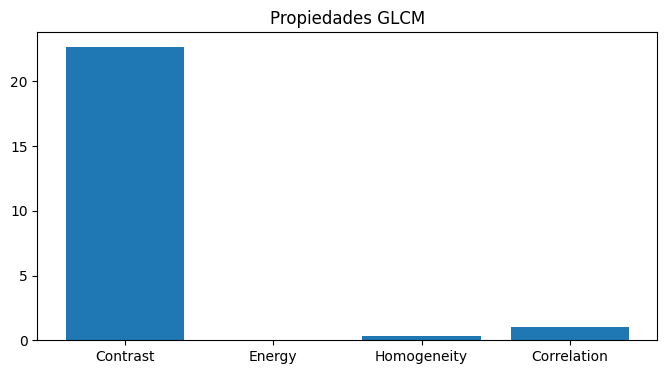

In [ ]:
def visualize_glcm_properties(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Extraer características GLCM
    glcm_features = extract_glcm_features(image)

    # Crear un gráfico de las propiedades GLCM
    properties = ['Contrast', 'Energy', 'Homogeneity', 'Correlation']
    plt.figure(figsize=(8, 4))
    plt.bar(properties, glcm_features[:4])  # Solo tomar las primeras 4 propiedades (una por ángulo)
    plt.title("Propiedades GLCM")
    plt.show()

# Llamar la función de visualización con una imagen de ejemplo
visualize_glcm_properties(image_paths_disaster_waste[0])


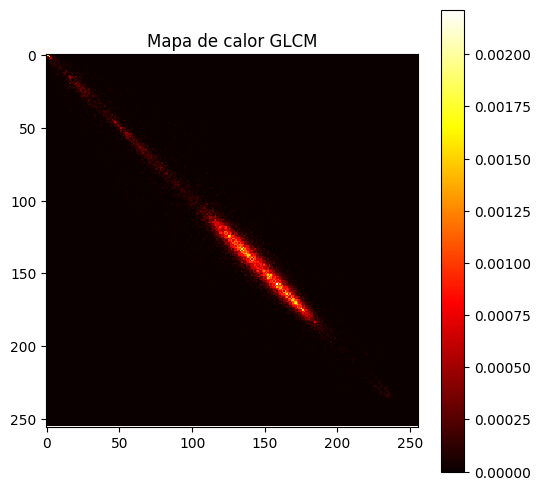

In [ ]:
def visualize_glcm_heatmap(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(image, (128, 128))  # Redimensionar si es necesario

    # Calcular GLCM
    glcm = graycomatrix(img_resized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Visualizar GLCM como un mapa de calor
    plt.figure(figsize=(6, 6))
    plt.imshow(glcm[:, :, 0, 0], cmap='hot', interpolation='nearest')
    plt.title("Mapa de calor GLCM")
    plt.colorbar()
    plt.show()

# Llamar a la función para una imagen de ejemplo
visualize_glcm_heatmap(image_paths_disaster_waste[20])


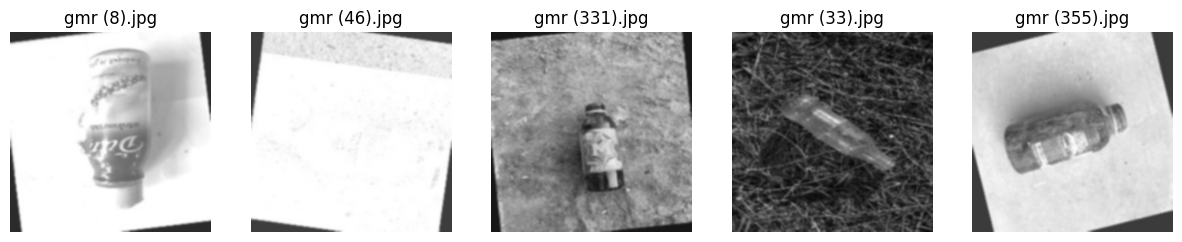

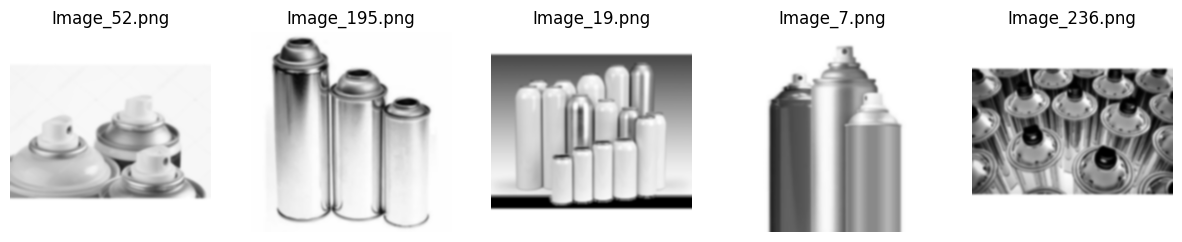

In [ ]:
def show_sample_images(image_path, num_images=5):
    #Muestra una muestra de imágenes procesadas en el directorio dado.
    images = []
    for root, dirs, files in os.walk(image_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))

    sample_images = images[:num_images]

    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')  # No mostrar los ejes
        plt.title(os.path.basename(img_path))  # Mostrar el nombre de la imagen

    plt.show()

show_sample_images(path_disaster_waste, num_images=5)
show_sample_images(path_recyclable_household, num_images=5)

In [ ]:
def print_directory_structure(root_dir, level=0):
    # verificar la estructura de directorios de forma recursiva
    indent = " " * (level * 4)  # Indentación
    print(f"{indent}{os.path.basename(root_dir)}/")
    level += 1
    for item in os.listdir(root_dir):
        path = os.path.join(root_dir, item)
        if os.path.isdir(path):
            print_directory_structure(path, level)

# Imprimir la estructura de carpetas final
print("Estructura de carpetas final para el dataset de Disaster Waste:")
print_directory_structure(path_disaster_waste)

print("\nEstructura de carpetas final para el dataset de Recyclable and Household Waste:")
print_directory_structure(path_recyclable_household)


Estructura de carpetas final para el dataset de Disaster Waste:
1/
    DWS-2 dataset/
        DWS-2/
            Glass Materials/
                Train/
                Test/
            Cement-Based Materials/
                Train/
                Test/
            Wooden Materials/
                Train/
                Test/
            Electronic Components/
                Train/
                Test/
            Metallic Materials/
                Train/
                Test/
    DWS-1 dataset/
        DWS-1/
            Glass Materials/
                Train/
                Test/
            Cement-Based Materials/
                Train/
                Test/
            Ceramic Materials/
                Train/
                Test/
            Electronic Components/
                Train/
                Test/
            Metallic Materials/
                Train/
                Test/

Estructura de carpetas final para el dataset de Recyclable and Household Waste:
1/
    im

In [ ]:
images = []
for root, dirs, files in os.walk(path_disaster_waste_train):
  for file in files:
    if file.endswith(('.jpg', '.jpeg', '.png')):
      images.append(os.path.join(root, file))
print(images[97])

/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Glass Materials/Train/gm n (294).jpg


/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Cement-Based Materials/Train/CB (459).jpg


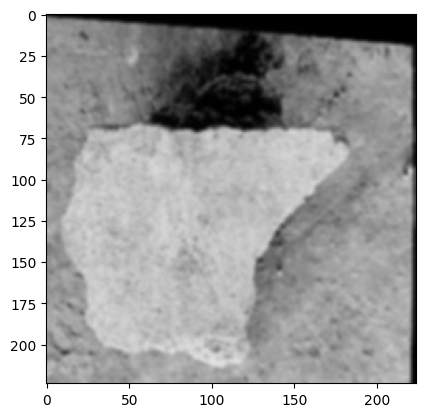

In [ ]:
new_features = extract_combined_features(images[1110], kmeans_model, num_clusters=50)
img = cv2.imread(images[1110])
print(images[1110])
plt.imshow(img)
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Crear el modelo k-NN con la distancia Euclidiana (p=2)
knn = NearestNeighbors(n_neighbors=5, metric='minkowski', p=2)  # Cambia p para otras métricas
knn.fit(disaster_waste_features)

# Buscar las imágenes más cercanas a la nueva imagen
distances, indices = knn.kneighbors([new_features])
print("Índices de las imágenes más similares:", indices[0])
print("Distancias:", distances[0])

Índices de las imágenes más similares: [1110  260 1163 1220 1688]
Distancias: [ 0.         20.80586728 21.1247324  22.27281824 22.49048099]


/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Cement-Based Materials/Train/CB (459).jpg


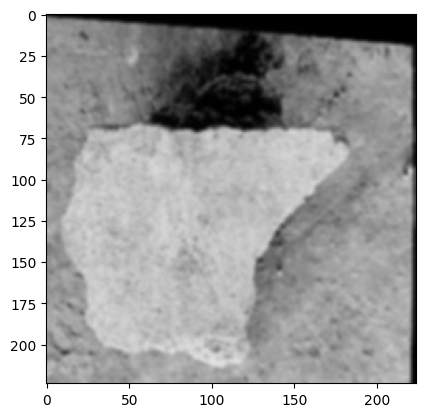

/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Glass Materials/Train/gm n (170).jpg


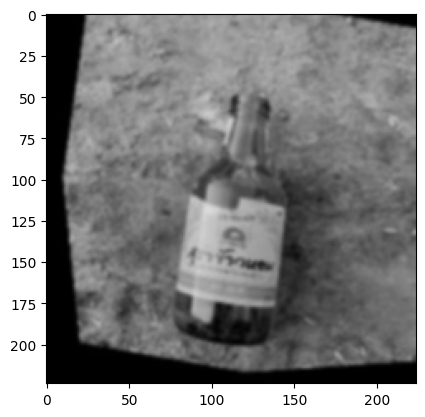

/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Cement-Based Materials/Train/CB (54).jpg


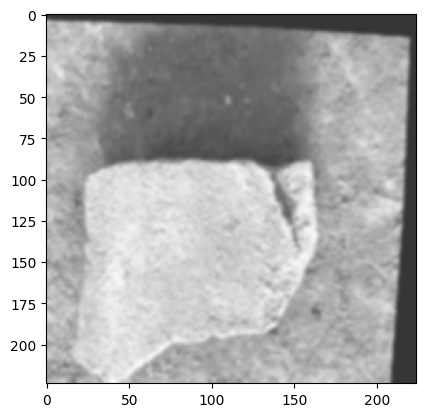

/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Cement-Based Materials/Train/CB (51).jpg


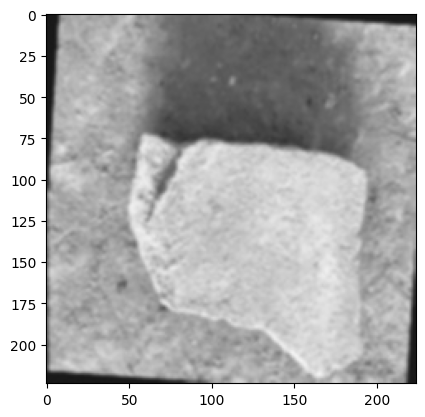

/root/.cache/kagglehub/datasets/engineeringubu/disaster-waste-dataset/versions/1/DWS-1 dataset/DWS-1/Ceramic Materials/Train/cm (205).jpg


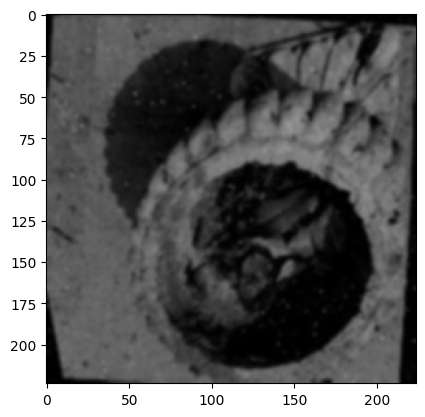

In [ ]:
for i in indices[0]:  # Iterate through individual indices within the array
    print(disaster_waste_labels[i])  # Access the label or path using the single index
    img = cv2.imread(disaster_waste_labels[i])  # Read the image using the correct path
    plt.imshow(img)
    plt.show()

